# Quantum models for two-dimensional function fitting. 


We simulate two quantum models that are used for multidimensional function fitting with data re-uploading structure. The two models use different circuit ansatzes: 
* **Line ansatz:** encodes all data-features in the same qudit. 
* **Parallel ansatz:** encodes the $M$ data-features in the same number of qudits.






In [1]:
# Import everything we need
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

#minimization 
from scipy.optimize import minimize

In [2]:
# Parameters for functions

class fitting_qubit: 
    def __init__(self, layers,ansatz, qubits, test_samples= 500, train_samples =1000, seed = 7):
        """Class that includes all the necessary for the fiting problem with one qubit
        
        Args: 
            - qubits (int): Number of qubits.
            - layers(int): Number of layers that our circuit ansatz will have. 
            - ansatz(int): Options. 
                            -1: Trainable gate: Ry(p1). Encoding gate: Rz(x)
                            -2: Trainable gate: Ry(p1)Rz(p2). Encoding gate: Rz(x)
                            -3: Trainable gate: Ry(p1)Rz(p2). Encoding gate: Rz(p3x)
            - test_samples: number of test data points.
            - train_samples: number ot train data points.
            - seed (int): Random seed
            """

        np.random.seed(seed)
        self.layers = layers 
        self.qubits = qubits

        #train and test dataset
        self.train_samples = int(np.sqrt(train_samples))
        self.test_samples =int(np.sqrt(test_samples))
        lins_tr = np.pi
        lins_te = np.pi+0.0001
        x1_train = np.linspace(-lins_tr,lins_tr, self.train_samples)
        x2_train = np.linspace(-lins_tr,lins_tr, self.train_samples)
        x1_test = np.linspace(-lins_te,lins_te, self.test_samples)
        x2_test = np.linspace(-lins_te,lins_te, self.test_samples)
        self.xtest = np.meshgrid(x1_test, x2_test)
        self.xtrain = np.meshgrid(x1_train, x2_train)
        self.function_train = self.funct(self.xtrain[0], self.xtrain[1])
        self.function_test = self.funct(self.xtest[0], self.xtest[1])


        self.ansatz = ansatz
        self.params = np.random.uniform(size=(self.layers+1, self.ansatz))


    def funct(self, x, y = None,):
        """
        Generate the target function
        
        Args: 
         - x,y : data point or array
        Returns:
         - g: target function """

        g =   -0.02+ 0.04*np.cos(2*x+y)+ 0.25*np.sin(x)-0.3*np.cos(2*y)-0.1*np.sin(x-y)

        return np.real(g) 



    def gates(name, param): 
        """
        This function implements the diferents gates for one qubit that we are going to use in the circuit

         Args:
            name (str): Name of the gate

        Returns:
            gate (array): quantum gate
         """
        j = 1j
        if name == 'Ry':
            gate = np.array([[np.cos(param/2),np.sin(param/2)], [-np.sin(param/2), np.cos(param/2)]], dtype='complex') 

        elif name == 'Rz': 
            gate = np.array([[np.exp(j*param/2),0],[0,np.exp(-j*param/2)] ], dtype='complex')

        elif name == 'Rx':
            gate = np.array([[np.cos(param/2),-j*np.sin(param/2)], [-j*np.sin(param/2), np.cos(param/2)]], dtype='complex')

        return gate

    



    def circuit(self, x, initial_state = None): 
        """This function simulates the quantum circuit model of a qubit
        Args: 
        - x (array): single data-point of the problem. 
        Returns: 
        - expval (float): Expected value of the pauli-Z observable after the state in the PQC. """
        
        #we set the initial state
        if initial_state == None: 
            initial_state = np.array([1,0], dtype='complex')

        params = self.params
        state = initial_state 

        #zero layer. A^(0) 
        state = np.dot(fitting_qubit.gates('Rz', params[0][0]), state)
        state = np.dot(fitting_qubit.gates('Ry', params[0][1]), state)
        state = np.dot(fitting_qubit.gates('Rz', params[0][2]), state)

        # l layers: S(x_1) A^(l)_1 S(x_2) A^(l)_2
        for p in params[1:]:
            # encoding
            state = np.dot(fitting_qubit.gates('Rz', x[0]), state)
            # trainable gates
            state = np.dot(fitting_qubit.gates('Rz', p[0]), state)
            state = np.dot(fitting_qubit.gates('Ry', p[1]), state)
            state = np.dot(fitting_qubit.gates('Rz', p[2]), state)
            # encoding
            state = np.dot(fitting_qubit.gates('Rz', x[1]), state)
            # trainable gates
            state = np.dot(fitting_qubit.gates('Rz', p[3]), state)
            state = np.dot(fitting_qubit.gates('Ry', p[4]), state)
            state = np.dot(fitting_qubit.gates('Rz', p[5]), state)

        
        expval = np.abs(state[0])**2-np.abs(state[1])**2
        return expval

    def cost_function(self, params = None):
        """
       Cost function consisting on the squared difference between the function output of the circuit (expceted value) and the real value of 
       the target function. It is averaged aver all training points.

        Args: 
        -params: The params will be updated after each step of the minimization method. 
        Returns: 
        - Value of the cost function."""

        if params is not None:
            self.params = params.reshape(self.layers+1,self.ansatz)
        loss = 0.0
        x1 = self.xtrain[0]
        x2 = self.xtrain[1]
        N = len(self.function_train)


        for i in range(N):
            for j in range(N):
                y_pred = self.circuit([x1[i,j], x2[i,j]])
                loss += (self.function_train[i,j]-y_pred)**2
        loss /= N**2
        return loss


    def minimize_funct(self,method='bfgs', options=None, compile = True):
        """"
       Minimization of the cost function in the space of the parameters. Then 
        it returns the value of the function when the optimization has finished and the 
        values of the parameters that acomplish the desired optimization."""
       
        m = minimize(lambda p: self.cost_function(p), x0 = self.params, method=method, 
                            options=options)


        result = m.fun
        parameters = m.x

        return result, parameters 


    def plot_data(self, params_opt, fig = None):
        """
        Args:
            x (array[tuple]): array of data points as tuples
            y (array[int]): array of data points as tuples
            params_opt (array): params after the optimization
        """

        
        self.params = params_opt.reshape(self.layers+1,self.ansatz)

        SSE= 0
        SST = 0
        average =np.sum(self.function_test)/self.function_test.size

        x1 = self.xtest[0]
        x2 = self.xtest[1]
        N = len(self.function_test)
        f_pred = np.zeros((N, N), dtype = 'complex')

        for i in range(N):
            for j in range(N):
                f_pred_x = self.circuit([x1[i,j], x2[i,j]])
                f_pred[i,j] = f_pred_x
                SSE += (self.function_test[i,j]- f_pred_x)**2
                SST +=(self.function_test[i,j]-average)**2


        R = 1- SSE/SST
        print('accuracy: ', R*100, '%')


        fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
        im1 = axes[0].contourf(x1,x2, np.real(self.function_test)) 
        im1 = axes[1].contourf(x1,x2, np.real(f_pred))


        axes[0].title.set_text('Target')
        axes[1].title.set_text('Predicted')
        axes[0].set_ylabel('$x_2$')
        axes[0].set_xlabel('$x_1$')
        axes[1].set_xlabel('$x_1$')
        axes[1].tick_params(axis='y', which = 'both', bottom=False, left = False, right = False,    
         top=False,         
            labelleft=False) 
        


        fig.subplots_adjust(right=0.8)
        fig.colorbar(im1, ax=axes.ravel().tolist())
        axes[1].text(x= 4, y = 3.4, s = '$f(x_1, x_2)$' )

       

        fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (11,4),subplot_kw={"projection": "3d"}) 

        surf1 = ax[0].plot_surface(x1,x2,np.real(self.function_test), cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False) 
        ax[0].view_init(30, 70)
        ax[0].title.set_text('Target')
        ax[0].set_ylabel('$x_2$')
        ax[0].set_xlabel('$x_1$')

       
        surf2 = ax[1].plot_surface(x1,x2,np.real(f_pred), cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False) 
        ax[1].view_init(30, 70)
        ax[1].title.set_text('Predicted')
        ax[1].set_ylabel('$x_2$')
        ax[1].set_xlabel('$x_1$')

        cbaxes = fig.add_axes([0.8, 0.2, 0.03, 0.6])

        fig.colorbar(surf2, ax=ax.ravel().tolist(), cax = cbaxes)
        fig.subplots_adjust(right=0.8)
        fig.subplots_adjust(wspace=0.1)
        plt.show()
        return np.real(f_pred)


Optimization terminated successfully.
         Current function value: 0.051633
         Iterations: 2082
         Function evaluations: 2775
accuracy:  38.46325840071716 %


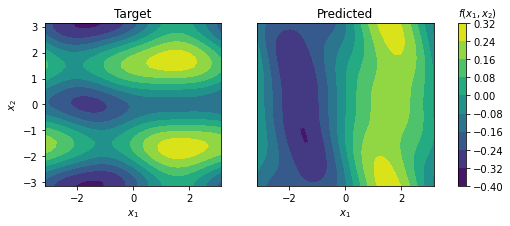

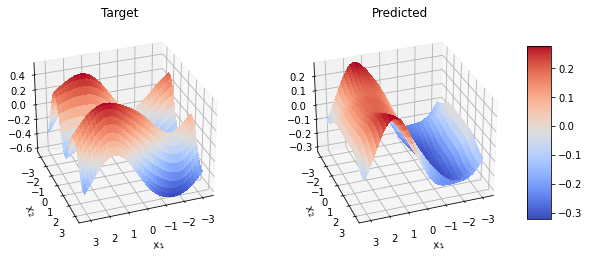

In [3]:

layers = 2
la_model = fitting_qubit(layers = layers, ansatz=6, qubits =1,test_samples=1500, train_samples = 500)
_,opt_params_la =  la_model.minimize_funct(method='NELDER-MEAD', 
options={'disp': True, 'maxiter': None}, compile= True)

f_pred = la_model.plot_data(opt_params_la)


In [8]:
# Parameters for functions

class fitting_qubits: 
    def __init__(self, layers,ansatz, qubits, coeffs = None, test_samples= 500, train_samples =1000, seed = 7, f_pred = None):
        """Class that includes all the necessary for the fiting problem with the parallel ansatz for two qubits
        
        Args: 
            - qubits (int): Number of qubits.
            - layers(int): Number of layers that our circuit ansatz will have. 
            - ansatz(int): Number of trainable parameters per layer.
             - test_samples: number of test data points.
            - train_samples: number ot train data points.
            - seed (int): Random seed
            """

        np.random.seed(seed)
        self.layers = layers 
        self.coeffs = coeffs
        self.qubits = qubits

        #train and test data-set
        self.train_samples = int(np.sqrt(train_samples))
        self.test_samples =int(np.sqrt(test_samples))
        lins_tr = np.pi
        lins_te = np.pi+0.0001
        x1_train = np.linspace(-lins_tr,lins_tr, self.train_samples)
        x2_train = np.linspace(-lins_tr,lins_tr, self.train_samples)
        x1_test = np.linspace(-lins_te,lins_te, self.test_samples)
        x2_test = np.linspace(-lins_te,lins_te, self.test_samples)
        self.xtest = np.meshgrid(x1_test, x2_test)
        self.xtrain = np.meshgrid(x1_train, x2_train)
        self.function_train = self.funct(self.xtrain[0], self.xtrain[1])
        self.function_test = self.funct(self.xtest[0], self.xtest[1])
        #predicted function of other model for comparisson
        self.one_qubit = f_pred




      


        self.ansatz = ansatz
        self.params = np.random.uniform(size=(self.layers+1, self.ansatz))
        self.layers_param = []



    def funct(self, x,y):
        """
        Generate the target function
        
        Args: 
         - x,y : data point or array
        Returns:
         - g: target function """

        g =   -0.02+ 0.04*np.cos(2*x+y)+ 0.25*np.sin(x)-0.3*np.cos(2*y)-0.1*np.sin(x-y)

        
        return np.real(g) 

    def gates(name, param=None): 
        """
        This function implements the diferents gates for one and two qubits that we are going to use in the circuit

         Args:
            name (str): Name of the gate

        Returns:
            gate (array): quantum gate
         """
        j = 1j
        if name == 'sigma_x':
            gate = np.array([[0,1],[1,0] ], dtype='complex')
            # gate = np.kron(sigma, sigma)
        elif name == 'sigma_y':
            gate = np.array([[0,-1j],[1j,0] ], dtype='complex')
            # gate = np.kron(sigma, sigma)
        elif name == 'sigma_z':
            gate = np.array([[1,0],[0,-1] ], dtype='complex')
            # gate = np.kron(sigma, sigma)
        elif name == 'Ry':
            gate = np.array([[np.cos(param/2),np.sin(param/2)], [-np.sin(param/2), np.cos(param/2)]], dtype='complex')
        elif name == 'Rz': 
            gate = np.array([[np.exp(j*param/2),0],[0,np.exp(-j*param/2)] ], dtype='complex')
        elif name == 'Rx':
            gate = np.array([[np.cos(param/2),-j*np.sin(param/2)], [-j*np.sin(param/2), np.cos(param/2)]], dtype='complex')
        elif name == 'CNOT1': 
            gate = np.array([[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]])
        elif name == 'CNOT2': 
            gate = np.array([[1,0,0,0], [0,0,0,1], [0,0,1,0], [0,1,0,0]])
        return gate


    #Here we implement the necessary gates to implemeent a general unitary transformation of two qubits (see https://www.mdpi.com/1099-4300/15/6/1963). 
    def A_gate(self, param):

        sigma_x_2 = np.kron(fitting_qubits.gates('sigma_x'), fitting_qubits.gates('sigma_x'))
        sigma_y_2 = np.kron(fitting_qubits.gates('sigma_y'), fitting_qubits.gates('sigma_y'))
        sigma_z_2 = np.kron(fitting_qubits.gates('sigma_z'), fitting_qubits.gates('sigma_z'))
        exp = -1j/2*(param[0]*sigma_x_2+ param[1]*sigma_y_2+ param[2]*sigma_z_2)
        unitary = expm(exp)
        return unitary 

    def k_gate(self,X):

        sigma_x = fitting_qubits.gates('sigma_x')
        sigma_y = fitting_qubits.gates('sigma_y')
        sigma_z = fitting_qubits.gates('sigma_z')
        exp_1 = expm(-1j/2*(X[0]*sigma_x+X[1]*sigma_y+X[2]*sigma_z))
        exp_2 = expm(-1j/2*(X[3]*sigma_x+X[4]*sigma_y+X[5]*sigma_z))
        return np.kron(exp_1, exp_2)


    def U_one_qubit(self,X): 

        unitary = np.dot(fitting_qubits.gates('Ry', param=X[1]), fitting_qubits.gates('Rz', param = X[0]))
        unitary = np.dot(fitting_qubits.gates('Rz',param = X[2]), unitary)
        return unitary

    def U_two_qubits(self, X1, X2): 

        return np.kron(self.U_one_qubit(X1), self.U_one_qubit(X2))
    
    

    def general_unitary_2qubits(self, params):

        unitary = np.dot(self.A_gate(params[6:9]), self.U_two_qubits(params[:3], params[3:6]))
        unitary = np.dot(self.U_two_qubits(params[9:12], params[12:]), unitary)



    def expval(self, st1):
        """This function is used to compute the expectation value of the sigma_z observable. We compute the 
        reduced density matrix of the first qubit in the quantum circuit and then the expected value of this state  """
        
        rho = np.outer(st1, np.conj(st1))
        rho_2 = np.zeros((2,2), dtype = 'complex' )
        rho_2[0][0] = rho[0][0]+rho[2][2]
        rho_2[1][1] = rho[1][1]+ rho[3][3]
        expval = rho_2[0][0]- rho_2[1][1]
        return np.real(expval)


    def circuit(self, x, initial_state = None): 

        """This function simulates the quantum circuit model of a qubit
        Args: 
        - x (array): single data-point of the problem. 
        Returns: 
        - state (array): quantum state after the PQC. 
        """
        if initial_state == None: 
            initial_state = np.array([1,0,0,0], dtype='complex')
        params = self.params
        state = initial_state 
       
        #zero layer. A^(0)
        state = np.dot(self.k_gate(params[0][:6]), state)
        state = np.dot(self.A_gate(params[0][6:9]), state)
        state = np.dot(self.A_gate(params[0][9:15]), state)

        # l layers. A^(0) S(x1)xS(x_2)
        for p in params[1:]:

            #encoding of each dimension in a different qubit
            state = np.dot(np.kron(fitting_qubits.gates('Rz', x[0]), fitting_qubits.gates('Rz', x[1])), state)

            #general processing transformation
            state = np.dot(self.k_gate(p[:6]), state)
            state = np.dot(self.A_gate(p[6:9]), state)
            state = np.dot(self.A_gate(p[9:15]), state)
        
        return state

    def cost_function(self, params = None):
        """
       Cost function consisting on the squared difference between the function output of the circuit (expceted value) and the real value of 
       the target function. It is averaged aver all training points.

        Args: 
        -params: The params will be updated after each step of the minimization method. 
        Returns: 
        - Value of the cost function.
        """

        if params is not None:
            self.params = params.reshape(self.layers+1, self.ansatz)
        loss = 0.0
        x1 = self.xtrain[0]
        x2 = self.xtrain[1]
        N = len(self.function_train)
        for i in range(N):
            for j in range(N):
                state_pred = self.circuit([x1[i,j], x2[i,j]])
                y_pred = self.expval(state_pred)
                loss += (self.function_train[i,j]-y_pred)**2
        loss /= N**2
        return loss

    def minimize_funct(self,method='bfgs', options=None, compile = True):
        """"
       Minimization of the cost function in the space of the parameters. Then 
        it returns the value of the function when the optimization has finished and the 
        values of the parameters that acomplish the desired optimization."""

        

        m = minimize(lambda p: self.cost_function(p), x0 = self.params, method=method, 
                            options=options)


        result = m.fun
        parameters = m.x


        return result, parameters



    def plot_data(self, params_opt, fig = None):
        """
        Args:
            x (array[tuple]): array of data points as tuples
            y (array[int]): array of data points as tuples
            params_opt (array): params after the optimization
        """

        
        self.params = params_opt.reshape(self.layers+1, self.ansatz)

        
        SSE= 0
        SST = 0
        average =np.sum(self.function_test)/self.function_test.size

        
        x1 = self.xtest[0]
        x2 = self.xtest[1]
        N = len(self.function_test)
        f_pred = np.zeros((N, N))
        f_pred_one = self.one_qubit

        for i in range(N):
            for j in range(N):
                f_pred_x = self.circuit([x1[i,j], x2[i,j]])
                f_pred[i,j] = self.expval(f_pred_x)
                SSE += (self.function_test[i,j]- f_pred[i,j])**2
                SST +=(self.function_test[i,j]-average)**2

        R = 1- SSE/SST
        print('accuracy: ', R*100, '%')


        fig = plt.figure(figsize=(12,11))
        ax = fig.add_subplot(2, 2, 2)
        ax.tick_params(axis = 'both', labelsize=18)
        im1 = ax.contourf(x1,x2, np.real(self.function_test), cmap=plt.cm.viridis) #,100)
        ax.set_ylabel('$x_2$', fontsize = 18)
        ax.text( x=-5.7, y=3.5, s= 'Target function', fontsize = 18)
        ax.text( x=3.9, y=3, s= '$f(x_1, x_2)$', fontsize = 18)


        ax = fig.add_subplot(2, 2, 1, projection='3d')


        surf1 = ax.plot_surface(x1,x2,np.real(self.function_test), cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False) 
        ax.view_init(30, 50)
        ax.set_ylabel('$x_2$', fontsize = 18, labelpad = 8)
        ax.set_xlabel('$x_1$', fontsize = 18, labelpad = 10)
        ax.tick_params(axis = 'both', labelsize=18, pad = 8)
        ax.zaxis.set_rotate_label(False)  
        ax.set_zlabel('$f(x_1, x_2)$', rotation = 90, fontsize = 18, labelpad= 17)


        ax = fig.add_subplot(2, 2, 4)

        im1 = ax.contourf(x1,x2, np.real(f_pred), cmap=plt.cm.viridis) 
        ax.set_title('Parallel ansatz', fontsize = 18, pad = 10)
        ax.set_xlabel('$x_1$', fontsize = 18)
        ax.tick_params(axis = 'both', labelsize=18)



        ax = fig.add_subplot(2, 2, 3)

        im1 = ax.contourf(x1,x2, np.real(f_pred_one), cmap=plt.cm.viridis) #,100)
        ax.set_title('Line ansatz',  fontsize = 18, pad = 10)
        ax.set_ylabel('$x_2$', fontsize = 18)
        ax.tick_params(axis = 'both', labelsize=18)
        ax.set_xlabel('$x_1$', fontsize = 18)



        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im1, cax=cbar_ax)
        cbar_ax.tick_params(labelsize=18)
        fig.savefig('simulation.pdf')





    




accuracy:  95.63392305185334 %


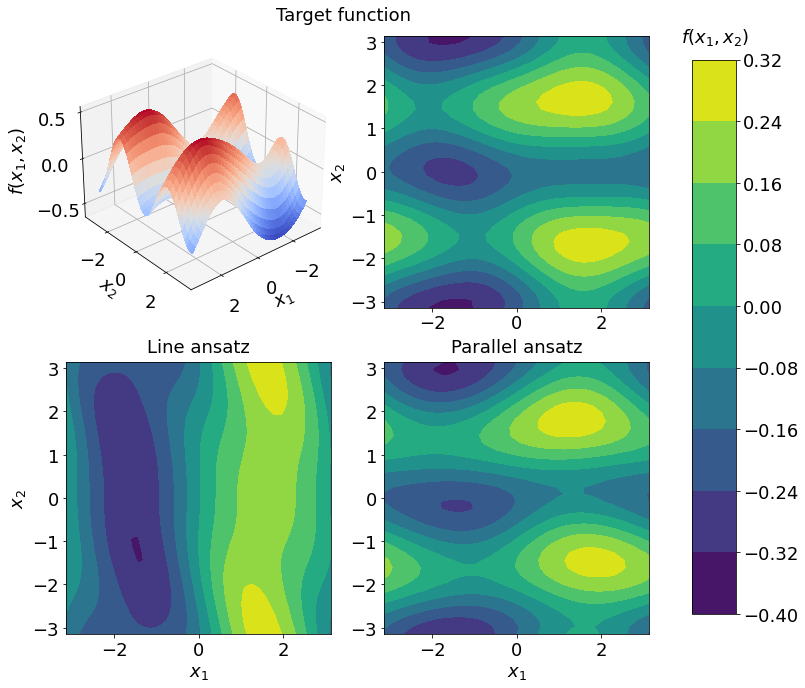

In [9]:
layers = 2

pa_model = fitting_qubits(layers=layers, ansatz=15, qubits=2, seed=18, f_pred = f_pred, test_samples=1500, train_samples = 500)
_,opt_params_pa = pa_model.minimize_funct(method='NELDER-MEAD', 
    options={'disp': True, 'maxiter': None}, compile= True)
pa_model.plot_data(params_opt=opt_params_pa)